In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from laspy.file import File
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

import sys

sys.path.insert(0,'..') # So we can import point_density_functions from parent directory
from point_density_functions import *
%load_ext autoreload
%matplotlib notebook

In [2]:
# Laefer
file_dir = '../../Data/parking_lot/'
filenames =list(pd.read_csv(file_dir+"filenames.txt",header=None)[0])
pt_files = list(pd.read_csv(file_dir+"pt_files.txt",header=None)[0])
# NYC
nyc_file_dir = '../../Data/NYC_topo/'
nyc_pt_file = ['las_points_NYC_flightid_975172.lz']
# USGS
usgs_file_dir = '../../Data/USGS/'
usgs_pt_files = ['las_points_flight_id_18TWK820985.lz']


# Corresponds to LAS 1.2 Point Data Record Format 1
columns_dublin_pt_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'return_number_byte',
    'classification_byte',
    'scan_angle',
    'user_data',
    'pt_src_id',
    'gps_time']

columns_point_cloud = [
    'X','Y','Z',
    'intensity',
    'flag_byte',
    'classification_flags',
    'classification_byte',
    'user_data',
    'scan_angle',
    'pt_src_id',
    'gps_time']

In [ ]:
# This works
# for filename in filenames:
#     create_df_hd5(file_dir,filename,columns_point_cloud)

### Supporting Functions for Horizontal Density

In [3]:
# Big parking lot rectangle
def rectangle(pt1,pt2,y_length,x_length):
    '''
    Function returns uv_inv and w, for use in selecting points within the rectangle
    Note: This function only works in 2D (horizontal plane)
    Inputs:
    pt1 - 2x1 numpy array with x and y coordinate for bottom point
    pt2 - 2xy numpy array with x and y coordinate for top point
    y_length - bottom-to-top length (positive is in direction of top from bottom point)
    x_length - left-to-right length (positive means pts are on left border, negative means they're on right)
    Outputs:
    uv_inv: 2xy numpy array - u and v are the sides of the rectangle.  uv = [u v] is a matrix with u and v as columns.
    w: 2x1 numpy array with (x,y) coordinates of reference (bottom) point.
    
    Reference: https://math.stackexchange.com/questions/190111/how-to-check-if-a-point-is-inside-a-rectangle
    '''
    unit_u = (pt2 - pt1)/np.linalg.norm(pt2-pt1)
    unit_v = np.array([unit_u[1],-1*unit_u[0]])
    u = unit_u*y_length
    v = unit_v*x_length
    uv = np.array([u,v]).T
    uv_inv = np.linalg.inv(uv)
    w = pt1
    return uv_inv,w,unit_u,unit_v

# rectangle_points_laefer = grab_points_big_rect(pt_files,file_dir,uv_inv,w)
# rectangle_points_nyc = grab_points_big_rect(nyc_pt_file,nyc_file_dir,uv_inv,w)
# rectangle_points_usgs = grab_points_big_rect(usgs_pt_files,usgs_file_dir,uv_inv,w)

In [4]:
def print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point):
    # Laefer
    sd_laefer_total = np.mean([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList])
    sd_laefer_sample = np.mean([ss.flight_list_laefer[1].sd_dist for ss in SampleFlightList])
    avg_flight_paths_laefer = np.mean([len(flight.flight_list_laefer) for flight in SampleFlightList])-2

    phis_laefer_total = [ss.phi_laefer_total for ss in SampleFlightList]
    phis_laefer_sample = [ss.phi_laefer_sample for ss in SampleFlightList]

    print("2019 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_laefer_list)))
    print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
    print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_laefer))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_total),np.std(phis_laefer_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_sample),np.std(phis_laefer_sample)))
    print("Total point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total))
    print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total/np.mean(phis_laefer_total)))

    # NYC
    phis_nyc_total = [ss.phi_nyc_total for ss in SampleFlightList]
    phis_nyc_sample = [ss.phi_nyc_sample for ss in SampleFlightList]
    avg_flight_paths_nyc = np.mean([len(flight.flight_list_nyc) for flight in SampleFlightList])-2

    sd_nyc_total = np.mean([ss.flight_list_nyc[0].sd_dist for ss in SampleFlightList])
    sd_nyc_sample = np.mean([ss.flight_list_nyc[1].sd_dist for ss in SampleFlightList])

    print("\n2017 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_nyc_list)))
    print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
    print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_nyc))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_nyc_total),np.std(phis_nyc_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_nyc_sample),np.std(phis_nyc_sample)))
    print("Total point dist from plane, SD: {:2.4f} feet".format(sd_nyc_total))
    print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_nyc_total/np.mean(phis_nyc_total)))

    # USGS
    phis_usgs_total = [ss.phi_usgs_total for ss in SampleFlightList]
    phis_usgs_sample = [ss.phi_usgs_sample for ss in SampleFlightList]
    avg_flight_paths_usgs = np.mean([len(flight.flight_list_usgs) for flight in SampleFlightList])-2

    sd_usgs_total = np.mean([ss.flight_list_usgs[0].sd_dist for ss in SampleFlightList])
    sd_usgs_sample = np.mean([ss.flight_list_usgs[1].sd_dist for ss in SampleFlightList])

    print("\n2014 scan (Horizontal, {} samples): \n".format(len(SampleFlightList))+"*"*30)
    print("Avg points per square: {:2.2f} points".format((4 * feet_from_point**2)*np.mean(pt_density_usgs_list)))
    print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_usgs_list),np.std(pt_density_usgs_list)))
    print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_usgs))
    print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_usgs_total),np.std(phis_usgs_total)))
    print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_usgs_sample),np.std(phis_usgs_sample)))
    print("Total point dist from plane, SD: {:2.4f} feet".format(sd_usgs_total))
    print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_usgs_total/np.mean(phis_usgs_total)))

## Sampling squares and Statistics

### Horizontal Density

In [5]:
# Aggregators
pt_density_usgs_list, pt_density_nyc_list, pt_density_laefer_list = [],[],[]
avg_height_diff = []
sd_height_usgs, sd_height_nyc, sd_height_laefer = [],[],[]
SampleFlightList = []

In [6]:
# Water front parking lot
pt1 = np.array([976534.92, 173979.05,0])
pt2 = np.array([976863.17, 174360.18,0])
u_length = np.linalg.norm(pt2-pt1)
v_length = 80
print("u_length: ",u_length)
pt3 = np.array([976595.53720051, 173926.84315177,0]) # Backed into from previous 2D v calculation
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],500,80)

rectangle_points_laefer = pd.read_pickle(file_dir+"rectangle_points_laefer.pkl")
rectangle_points_nyc = pd.read_pickle(file_dir+"rectangle_points_nyc.pkl")
rectangle_points_usgs = pd.read_pickle(usgs_file_dir+"rectangle_points_usgs.pkl")

u_length:  502.99914453207924


In [7]:
# Create center_points
feet_from_point = 3.281/np.sqrt(2)
center_points = center_point_sample(5000,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=[0.05,0.05])
mean_z = rectangle_points_laefer['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points_usgs = in_horizontal_square(rectangle_points_usgs,center_point[:2],feet_from_point)
    square_points_nyc = in_horizontal_square(rectangle_points_nyc,center_point[:2],feet_from_point)
    square_points_laefer = in_horizontal_square(rectangle_points_laefer,center_point[:2],feet_from_point)
    
    laefer_flight_count = len(square_points_laefer['flight_id'].unique())
    nyc_flight_count = len(square_points_nyc['flight_id'].unique())
    usgs_flight_count = len(square_points_usgs['flight_id'].unique())
   
    laefer_density = square_points_laefer.shape[0] / laefer_flight_count
    try:
        nyc_density = square_points_nyc.shape[0]/nyc_flight_count
    except ZeroDivisionError:
        nyc_density = 0
        
    try:
        usgs_density = square_points_usgs.shape[0] / usgs_flight_count
    except ZeroDivisionError:
        usgs_density = 0
 
    # If z_max > 10, <6 for any dataset, skip it
    if (square_points_nyc['z_scaled'].max()<mean_z+3) & \
       (square_points_usgs['z_scaled'].max()<mean_z+3) & \
       (square_points_laefer['z_scaled'].max()<mean_z+3):
        # Statistics!
                
        # Point density
        num_points_nyc = square_points_nyc.shape[0]
        pt_density_nyc_list.append(num_points_nyc / (4 * feet_from_point**2))        
        num_points_usgs = square_points_usgs.shape[0]
        pt_density_usgs_list.append(num_points_usgs / (4 * feet_from_point**2))        
        num_points_laefer = square_points_laefer.shape[0]
        pt_density_laefer_list.append(num_points_laefer / (4 * feet_from_point**2))        
        
        # Flight path specifics
        laefer_flight_list = create_flight_list(square_points_laefer)
        usgs_flight_list = create_flight_list(square_points_usgs)
        nyc_flight_list = create_flight_list(square_points_nyc)
        # Create SampleSquare from all flight passes
        ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        # Collect SampleSquares
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

../point_density_functions.py:447: RuntimeWarning:

invalid value encountered in double_scalars

../point_density_functions.py:445: RuntimeWarning:

invalid value encountered in double_scalars

../point_density_fun

In [8]:
print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point)

2019 scan (Horizontal, 3469 samples): 
******************************
Avg points per square: 1044.82 points
Avg density: 48.5289 pts/sqft (SD: 1.7484)
Avg number of flight paths per square: 19.83

phi_total: 1.2887 (SD: 0.1848)
phi_sample: 1.2078 (SD: 0.3374)
Total point dist from plane, SD: 0.0339 feet
Avg flight point dist from plane, SD: 0.0263 feet

2017 scan (Horizontal, 3469 samples): 
******************************
Avg points per square: 24.41 points
Avg density: 1.1336 pts/sqft (SD: 0.1194)
Avg number of flight paths per square: 3.00

phi_total: 1.2574 (SD: 0.1955)
phi_sample: 0.9985 (SD: 0.3567)
Total point dist from plane, SD: 0.0629 feet
Avg flight point dist from plane, SD: 0.0500 feet

2014 scan (Horizontal, 3469 samples): 
******************************
Avg points per square: 14.40 points
Avg density: 0.6688 pts/sqft (SD: 0.3552)
Avg number of flight paths per square: 2.65

phi_total: nan (SD: nan)
phi_sample: nan (SD: nan)
Total point dist from plane, SD: 0.1460 feet
Avg

In [9]:
# Back parking lot
u_length = 200
v_length = 40
pt1 = np.array([977221.16,173403.09,0])
pt2 = np.array([977345.97611538, 173559.36199794,0])
uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

pt3 = np.concatenate((w + unit_v*v_length,np.zeros(1)))
rectangle_points_laefer=pd.read_pickle(file_dir+"rectangle_points_back_parking_laefer.pkl")
rectangle_points_nyc=pd.read_pickle(file_dir+"rectangle_points_back_parking_nyc.pkl")
rectangle_points_usgs=pd.read_pickle(usgs_file_dir+"rectangle_points_back_parking_usgs.pkl")

In [10]:
# Create center_points
feet_from_point = 3.281/np.sqrt(2)
center_points = center_point_sample(5000,pt1,pt2,pt3,u_length=u_length,v_length=v_length,border=[0.05,0.05])
mean_z = rectangle_points_laefer['z_scaled'].mean()
pts_thrown_out = 0

for center_point in center_points:
    square_points_usgs = in_horizontal_square(rectangle_points_usgs,center_point[:2],feet_from_point)
    square_points_nyc = in_horizontal_square(rectangle_points_nyc,center_point[:2],feet_from_point)
    square_points_laefer = in_horizontal_square(rectangle_points_laefer,center_point[:2],feet_from_point)
    
    laefer_flight_count = len(square_points_laefer['flight_id'].unique())
    nyc_flight_count = len(square_points_nyc['flight_id'].unique())
    usgs_flight_count = len(square_points_usgs['flight_id'].unique())
   
    laefer_density = square_points_laefer.shape[0] / laefer_flight_count
    try:
        nyc_density = square_points_nyc.shape[0]/nyc_flight_count
    except ZeroDivisionError:
        nyc_density = 0
    
    try:
        usgs_density = square_points_usgs.shape[0] / usgs_flight_count
    except ZeroDivisionError:
        usgs_density = 0
 
    # If z_max > 10, <6 for any dataset, skip it
    if (square_points_nyc['z_scaled'].max()<mean_z+3) & \
       (square_points_usgs['z_scaled'].max()<mean_z+3) & \
       (square_points_laefer['z_scaled'].max()<mean_z+3):
        # Statistics!
                
        # Point density
        num_points_nyc = square_points_nyc.shape[0]
        pt_density_nyc_list.append(num_points_nyc / (4 * feet_from_point**2))        
        num_points_usgs = square_points_usgs.shape[0]
        pt_density_usgs_list.append(num_points_usgs / (4 * feet_from_point**2))        
        num_points_laefer = square_points_laefer.shape[0]
        pt_density_laefer_list.append(num_points_laefer / (4 * feet_from_point**2))        
        
        # Flight path specifics
        laefer_flight_list = create_flight_list(square_points_laefer)
        usgs_flight_list = create_flight_list(square_points_usgs)
        nyc_flight_list = create_flight_list(square_points_nyc)
        # Create SampleSquare from all flight passes
        ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                          y=center_point[1],feet_from_point=feet_from_point)
        # Collect SampleSquares
        SampleFlightList.append(ss)
        
    else:
        pts_thrown_out +=1

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
print_out(SampleFlightList,pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list,feet_from_point)

2019 scan (Horizontal, 7970 samples): 
******************************
Avg points per square: 1025.27 points
Avg density: 47.6207 pts/sqft (SD: 2.1557)
Avg number of flight paths per square: 19.78

phi_total: 1.2272 (SD: 0.1656)
phi_sample: 1.1586 (SD: 0.3210)
Total point dist from plane, SD: 0.0314 feet
Avg flight point dist from plane, SD: 0.0256 feet

2017 scan (Horizontal, 7970 samples): 
******************************
Avg points per square: 21.90 points
Avg density: 1.0170 pts/sqft (SD: 0.2463)
Avg number of flight paths per square: 3.00

phi_total: 1.2220 (SD: 0.1847)
phi_sample: 0.9148 (SD: 0.3600)
Total point dist from plane, SD: 0.0518 feet
Avg flight point dist from plane, SD: 0.0424 feet

2014 scan (Horizontal, 7970 samples): 
******************************
Avg points per square: 12.95 points
Avg density: 0.6015 pts/sqft (SD: 0.2534)
Avg number of flight paths per square: 2.83

phi_total: nan (SD: nan)
phi_sample: nan (SD: nan)
Total point dist from plane, SD: 0.1295 feet
Avg

In [12]:
cw_df = pd.DataFrame([flight.error_decomp_laefer for flight in SampleFlightList],columns=['laefer_C','laefer_W','laefer_rmse'])
cw_df['nyc_C'] = [flight.error_decomp_nyc[0] for flight in SampleFlightList]
cw_df['nyc_W'] = [flight.error_decomp_nyc[1] for flight in SampleFlightList]
cw_df['nyc_rmse'] = [flight.error_decomp_nyc[2] for flight in SampleFlightList]

cw_df['usgs_C'] = [flight.error_decomp_usgs[0] for flight in SampleFlightList]
cw_df['usgs_W'] = [flight.error_decomp_usgs[1] for flight in SampleFlightList]
cw_df['usgs_rmse'] = [flight.error_decomp_usgs[2] for flight in SampleFlightList]

(cw_df/3.28084).describe()

,laefer_C,laefer_W,laefer_rmse,nyc_C,nyc_W,nyc_rmse,usgs_C,usgs_W,usgs_rmse
count,7970.000000,7970.000000,7970.000000,7970.000000,7970.000000,7970.000000,7970.000000,7970.000000,7970.000000
mean,0.004169,0.008494,0.009563,0.007004,0.013778,0.015798,0.020280,0.032343,0.039460
std,0.004347,0.008377,0.009336,0.005081,0.013407,0.013960,0.011982,0.012894,0.014496
min,0.001619,0.004871,0.005845,0.000057,0.003375,0.004981,0.000000,0.000000,0.000000
25%,0.003188,0.006686,0.007676,0.004095,0.010545,0.012002,0.011715,0.025208,0.031547
50%,0.003924,0.007441,0.008393,0.006185,0.012130,0.013963,0.018554,0.031178,0.037796
75%,0.004683,0.008297,0.009275,0.008870,0.013990,0.016326,0.026525,0.037171,0.045013
max,0.247841,0.212274,0.308197,0.098667,0.315029,0.315790,0.118160,0.241239,0.251262


164239: 0.0096
164445: 0.0061
164640: 0.0182
164845: 0.0199
165019: 0.0344
172007: 0.0079
172201: 0.0079
172416: 0.0094
172558: 0.0037
172753: 0.0098
180428: 0.0084
180632: 0.0043
180819: 0.0102
181004: 0.0189
181155: 0.0350
195634: 0.0084
195833: 0.0115
200024: 0.0127
200212: 0.0100
200348: 0.0132
200600: 0.0217
172928: 0.0199
164039: 0.0050
200742: 0.0177
195235: 0.0201
163824: 0.0060
171553: 0.0131
171754: 0.0129
175659: 0.0125
175842: 0.0080
180048: 0.0048
180231: 0.0074
163425: 0.0116


Text(0, 0.5, 'Distribution of flight passes')

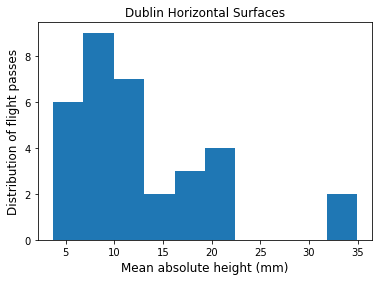

In [13]:
# Collect all heights by flight id
from collections import defaultdict

flight_id_dict = defaultdict(list)

for sample_num in range(len(SampleFlightList)):
    try:
        dd = dict([(fp.flight_id,fp.h) for fp in SampleFlightList[sample_num].flight_list_laefer[2:]])
        for key in dd.keys():
            flight_id_dict[key].append(dd[key])
    except AttributeError: 
        pass

h_dist = []
for key in flight_id_dict.keys():
    mean_h = np.mean([abs(v) for v in flight_id_dict[key]])
    h_dist.append(1000*mean_h)
    print("{:2}: {:2.4f}".format(key,mean_h))

# Plot distribution of mean abs(heights)
plt.hist(h_dist)
plt.title("Dublin Horizontal Surfaces",fontsize=12)
plt.xlabel("Mean absolute height (mm)",fontsize=12)
plt.ylabel("Distribution of flight passes",fontsize=12)

In [ ]:
l_rmse = [ss.flight_list_laefer[0].square_dist \
/ss.flight_list_laefer[0].num_points for ss in SampleFlightList]
np.sqrt(l_rmse).mean()

In [ ]:
cw_df['laefer_rmse'].mean()

In [ ]:
cw_df['nyc_rmse'].mean()

In [ ]:
print("Mean Distance from plane\n"+"*"*30)
print("2019: {:2.4f} (SD: {:2.4f})".format(np.mean([ss.delta_h_mean_laefer for ss in SampleFlightList]),np.mean([ss.delta_h_sd_laefer for ss in SampleFlightList])))
print("2017: {:2.4f} (SD: {:2.4f})".format(np.mean([ss.delta_h_mean_nyc for ss in SampleFlightList]),np.mean([ss.delta_h_sd_nyc for ss in SampleFlightList])))
print("2014: {:2.4f} (SD: {:2.4f})".format(np.mean([ss.delta_h_mean_usgs for ss in SampleFlightList]),np.mean([ss.delta_h_sd_usgs for ss in SampleFlightList])))

print("\nCosine Similarity\n"+"*"*30)
print("{:2.4f}".format(np.mean([np.mean(ss.cosine_sim_matrix_laefer) for ss in SampleFlightList])))
print("{:2.4f}".format(np.mean([np.mean(ss.cosine_sim_matrix_nyc) for ss in SampleFlightList])))
print("{:2.4f}".format(np.mean([np.mean(ss.cosine_sim_matrix_usgs) for ss in SampleFlightList])))

In [ ]:
# #Parking lot in between army terminal buildings
# u_length = 200
# v_length = 40
# pt1 = np.array([976975.96, 173882.3,0])
# pt2 = np.array([977107.27980512, 174033.14796579,0])
# uv_inv,w,unit_u,unit_v = rectangle(pt1[:2],pt2[:2],u_length,v_length)

# pt3 = np.concatenate((w + unit_v*v_length,np.zeros(1)))

# rectangle_points_laefer = pd.read_pickle(file_dir+"rectangle_points_middle_parking_laefer.pkl")
# rectangle_points_nyc = pd.read_pickle(file_dir+"rectangle_points_middle_parking_nyc.pkl")
# rectangle_points_usgs = pd.read_pickle(usgs_file_dir+"rectangle_points_middle_parking_usgs.pkl")

## Vertical density
Identifying point at corner of building to quantify the vertical point density.  
Center point: 	40.645854, 	-74.025299  
Easting - 977229.375  
Northing - 174579.42

In [ ]:
# Southern wall of Army Terminal Bldg
# middle_pt = np.array([976617.27,173802.86,58])
# Extract from all files, the points within feet_from_pt in the xy-plane of the middle wall point
# square_points_vertical_laefer = grab_points(pt_files,file_dir,middle_pt[0],middle_pt[1],9)
# square_points_vertical_nyc = grab_points(nyc_pt_file,nyc_file_dir,middle_pt[0],middle_pt[1],9)
# square_points_vertical_usgs = grab_points(usgs_pt_files,usgs_file_dir,middle_pt[0],middle_pt[1],9)

In [ ]:
def vert_density(square_points_list, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt, 
                 feet_from_pt,
                 SampleFlightList=[],
                 pt_density_list=[[],[],[]],
                 sd_wall_list=[[],[],[]],
                 wall_face_list=None
                 ):
    # Unzip the list
    square_points_laefer,square_points_nyc,square_points_usgs = \
    square_points_list[0],square_points_list[1],square_points_list[2]
    
    pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list = \
    pt_density_list[0],pt_density_list[1],pt_density_list[2]
    
    sd_wall_dist_laefer,sd_wall_dist_nyc,sd_wall_dist_usgs = \
    sd_wall_list[0],sd_wall_list[1],sd_wall_list[2] 
    # Create aggregators if not provided
    
    
    # Calculate norm_vector from 3 points, to define plane and extract the wall face
    norm = np.cross(middle_pt - right_pt,(left_pt-right_pt))
    norm = norm / np.linalg.norm(norm)

    # Extract the wall face, above 15ft and below 120ft to avoid roof and grouund points
    wall_face_laefer = grab_wall_face(square_points_laefer,norm, middle_pt,15,110,5e-1)
    wall_face_nyc = grab_wall_face(square_points_nyc,norm, middle_pt,15,110,5e-1)
    wall_face_usgs = grab_wall_face(square_points_usgs,norm, middle_pt,15,110,5e-1)

    # Fit a plane, create norm_vector, calculate dist_from_plane
    norm_vector_laefer,_,wall_face_laefer,_ = plane_fit(wall_face_laefer) 
    norm_vector_nyc,_,wall_face_nyc,_ = plane_fit(wall_face_nyc) 
    norm_vector_usgs,_,wall_face_usgs,_ = plane_fit(wall_face_usgs) 
    
    # Calculate the rectangle side length, based on points
    u_length = np.linalg.norm(bottom_left_pt-top_left_pt)
    v_length = np.linalg.norm(bottom_left_pt-bottom_right_pt)
    print("u_length: {:2.2f}m".format(u_length/3.28084))
    print("v_length: {:2.2f}m".format(v_length/3.28084))

    # Sample points in wall
    #Note 0.28 border_v comes from: (3.5/2) (half-meter feet_from_point) / v_length (with some buffer)
    feet_from_pt_v = 3.5
    feet_from_pt_u = 3.5
    border = [0,0]
    border[0] = 1.08*(feet_from_pt_u / u_length)
    border[1] = 1.08*(feet_from_pt_v / v_length)
    # For density up the wall below
    try:
        center_points_old = center_points
    except:
        pass
    center_points = center_point_sample(2500,
                        bottom_left_pt,top_left_pt,bottom_right_pt,
                        u_length=u_length,v_length=v_length,border=border)
    
    # Main Loop through the sample points
    pts_thrown_out = 0

    for center_point in center_points:
        square_points_usgs,pt_density_usgs = in_vertical_square(wall_face_usgs,
                                                    norm_vector_usgs,
                                                    center_point,
                                                    feet_from_pt_v,
                                                    feet_from_pt_u)
        square_points_nyc,pt_density_nyc = in_vertical_square(wall_face_nyc,
                                                    norm_vector_nyc,
                                                    center_point,
                                                    feet_from_pt_v,
                                                    feet_from_pt_u)
        square_points_laefer,pt_density_laefer = in_vertical_square(wall_face_laefer,
                                                    norm_vector_laefer,
                                                    center_point,
                                                    feet_from_pt_v,
                                                    feet_from_pt_u)
        laefer_flight_count = len(square_points_laefer['flight_id'].unique())
        nyc_flight_count = len(square_points_nyc['flight_id'].unique())
        usgs_flight_count = len(square_points_usgs['flight_id'].unique())

        # Statistics!

        # Point density
        num_points_laefer = square_points_laefer.shape[0]
        pt_density_laefer_list.append(pt_density_laefer)        
        num_points_usgs = square_points_usgs.shape[0]
        pt_density_usgs_list.append(pt_density_usgs)        
        num_points_nyc = square_points_nyc.shape[0]
        pt_density_nyc_list.append(pt_density_nyc)        
        

        # Fit a plane
        if square_points_laefer.shape[0] > 0:
            norm_vector_laefer,_,square_points_laefer,_ = plane_fit(square_points_laefer)
            laefer_flight_list = create_flight_list(square_points_laefer)
        else:
            laefer_flight_list=None

        if square_points_nyc.shape[0] > 0:
            norm_vector_nyc,_,square_points_nyc,_ = plane_fit(square_points_nyc)
            nyc_flight_list = create_flight_list(square_points_nyc)
        else:
            nyc_flight_list=None

        if square_points_usgs.shape[0] > 0:
            norm_vector_usgs,_,square_points_usgs,_ = plane_fit(square_points_usgs)
            usgs_flight_list = create_flight_list(square_points_usgs)
        else:
            usgs_flight_list=None
        # Flight path specifics
        ss = SampleSquare(laefer_flight_list, nyc_flight_list,usgs_flight_list, x = center_point[0], \
                          y=center_point[1],z=center_point[2],feet_from_point=[feet_from_pt_v,feet_from_pt_u])
        SampleFlightList.append(ss)    
    
    # Print outs
    print("Pts in Laefer: {}".format(wall_face_laefer.shape[0]))
    print("Pts in NYC: {}".format(wall_face_nyc.shape[0]))
    print("Pts in USGS: {}".format(wall_face_usgs.shape[0]))

    print("Vertical face point density over {:d} samples".format(len(pt_density_laefer_list)))
    print("*"*30)
    print("USGS avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_usgs_list),np.std(pt_density_usgs_list)))
    print("NYC avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_nyc_list),np.std(pt_density_nyc_list)))
    print("Laefer avg density: {:2.4f} (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
    
    # Output
    wall_face_list = [wall_face_laefer,wall_face_nyc,wall_face_usgs]
    pt_density_list = [pt_density_laefer_list,pt_density_nyc_list,pt_density_usgs_list]
    sd_wall_list = [sd_wall_dist_laefer,sd_wall_dist_nyc,sd_wall_dist_usgs]
    
    return SampleFlightList, wall_face_list, pt_density_list, sd_wall_list

In [ ]:
# Aggregators
pt_density_list= [[],[],[]]
sd_wall_list=[[],[],[]]
SampleFlightList = []

In [ ]:
# Other side of the windows
middle_pt = np.array([977214.86,174562.64,58.762])
right_pt = np.array([977213.577,174561.01,111.614])
left_pt = np.array([977217.294, 174565.64, 33.483])
bottom_left_pt= np.array([977217.09,174565.64,25.809])
top_left_pt = np.array([977217.09,174565.64,115.80])
bottom_right_pt = np.array([977213.026,174560.064,25.809])
feet_from_pt = 3.5

# Right vertical wall
square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/right_wall_vertical_laefer.pkl")
square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/right_wall_vertical_nyc.pkl")
square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/right_wall_vertical_usgs.pkl")

In [ ]:
square_points_list = [square_points_vertical_laefer,square_points_vertical_nyc,square_points_vertical_usgs]
SampleFlightList, wall_face_list, pt_density_list, sd_wall_list = \
vert_density(square_points_list, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt, 
                 feet_from_pt,
                 SampleFlightList,    
                 pt_density_list,
                 sd_wall_list
                 )

In [ ]:
wall_face_nyc = wall_face_list[2]
flight_ids = wall_face_nyc['flight_id'].unique()
wall_face_nyc['pts_bins'] = pd.cut((wall_face_nyc['z_scaled']-9)/3.28084, \
                                      bins=range(0,40,3), \
                                      labels=range(3,40,3))

for f in flight_ids:
    flight_pts = wall_face_nyc[wall_face_nyc['flight_id']==f]
    # Num of points
    print("\n\nDensity for flight id {}:".format(f),flight_pts.groupby('pts_bins')['X'].count()/(3*2.1))

In [ ]:
# Outer wall (B)
middle_pt = np.array([977223.71,174573.7,75.141])
right_pt = np.array([977221.44, 174571.037, 68.44])
left_pt = np.array([977226.47, 174577.23, 36.958])
bottom_left_pt = np.array([977225.752, 174576.37, 25.393])
top_left_pt = np.array([977225.752, 174576.37, 117.937])
bottom_right_pt = np.array([977221.605,174571.074,25.393])
feet_from_pt = 3.5

# Left vertical wall
square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/left_wall_vertical_laefer.pkl")
square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/left_wall_vertical_nyc.pkl")
square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/left_wall_vertical_usgs.pkl")

In [ ]:
square_points_list = [square_points_vertical_laefer,square_points_vertical_nyc,square_points_vertical_usgs]
SampleFlightList, wall_face_list, pt_density_list, sd_wall_list = \
vert_density(square_points_list, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt, 
                 feet_from_pt,
                 SampleFlightList,  
                 pt_density_list,
                 sd_wall_list
                 )

# # Append wall_face to wall_face_laefer_total
# wall_face_laefer_total = wall_face_laefer_total.append(wall_face_list[0])
# wall_face_laefer_total.shape

In [ ]:
wall_face_nyc = wall_face_list[2]
flight_ids = wall_face_nyc['flight_id'].unique()
wall_face_nyc['pts_bins'] = pd.cut((wall_face_nyc['z_scaled']-9)/3.28084, \
                                      bins=range(0,40,3), \
                                      labels=range(3,40,3))

for f in flight_ids:
    flight_pts = wall_face_nyc[wall_face_nyc['flight_id']==f]
    # Num of points
    print("\n\nDensity for flight id {}:".format(f),flight_pts.groupby('pts_bins')['X'].count()/(3*2.05))

In [ ]:
# Wall at other end of Army Terminal Bldg (C)
middle_pt = np.array([976665.066,173867.613,75.54])
right_pt = np.array([976663.22,173865.13,28.945])
left_pt = np.array([976666.636,173869.511,54.121])
bottom_left_pt= np.array([976665.002991,173867.726,13.903])
top_left_pt = np.array([976665.002991,173867.726,110.903])
bottom_right_pt = np.array([976662.514,173864.906,15.875])

feet_from_pt = 3.5

square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/wall_c_laefer.pkl")
square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/wall_c_nyc.pkl")
square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/wall_c_usgs.pkl")

In [ ]:
square_points_list = [square_points_vertical_laefer,square_points_vertical_nyc,square_points_vertical_usgs]
SampleFlightList, wall_face_list, pt_density_list, sd_wall_list = \
vert_density(square_points_list, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt, 
                 feet_from_pt,
                 SampleFlightList,      
                 pt_density_list,
                 sd_wall_list
                 )
# # Append wall_face to wall_face_laefer_total
# wall_face_laefer_total = wall_face_laefer_total.append(wall_face_list[0])
# wall_face_laefer_total.shape

In [ ]:
wall_face_nyc = wall_face_list[2]
flight_ids = wall_face_nyc['flight_id'].unique()
wall_face_nyc['pts_bins'] = pd.cut((wall_face_nyc['z_scaled']-9)/3.28084, \
                                      bins=range(0,40,3), \
                                      labels=range(3,40,3))

for f in flight_ids:
    flight_pts = wall_face_nyc[wall_face_nyc['flight_id']==f]
    # Num of points
    print("\n\nDensity for flight id {}:".format(f),flight_pts.groupby('pts_bins')['X'].count()/(3*1.29))

In [ ]:
# Wall in middle of Army Terminal Bldg (D)
middle_pt = np.array([976763.544,173992.004,23.858])
right_pt = np.array([976762.356,173990.422,101.224])
left_pt = np.array([976765.87,173994.878,87.094])
bottom_left_pt= np.array([976765.87,173994.878,13.9])
top_left_pt = np.array([976765.87,173994.878,110.9])
bottom_right_pt = np.array([976762.356,173990.422,13.9])

feet_from_pt = 3.5/2

square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/wall_d_laefer.pkl")
square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/wall_d_nyc.pkl")
square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/wall_d_usgs.pkl")

In [ ]:
square_points_list = [square_points_vertical_laefer,square_points_vertical_nyc,square_points_vertical_usgs]
SampleFlightList, wall_face_list, pt_density_list, sd_wall_list = \
vert_density(square_points_list, 
                 middle_pt, 
                 right_pt, 
                 left_pt, 
                 bottom_left_pt, 
                 feet_from_pt,
                 SampleFlightList,  
                 pt_density_list,
                 sd_wall_list
                 )
# # Append wall_face to wall_face_laefer_total
# wall_face_laefer_total = wall_face_laefer_total.append(wall_face_list[0])
# wall_face_laefer_total.shape

In [ ]:
wall_face_nyc = wall_face_list[2]
flight_ids = wall_face_nyc['flight_id'].unique()
wall_face_nyc['pts_bins'] = pd.cut((wall_face_nyc['z_scaled']-9)/3.28084, \
                                      bins=range(0,40,3), \
                                      labels=range(3,40,3))

for f in flight_ids:
    flight_pts = wall_face_nyc[wall_face_nyc['flight_id']==f]
    # Num of points
    print("\n\nDensity for flight id {}:".format(f),flight_pts.groupby('pts_bins')['X'].count()/(3*1.73))

In [ ]:
# # South wall!  For vertical density of NYC
# middle_pt = np.array([976617.27,173802.86,58])
# right_pt = np.array([976620.67,173800.14,50])
# left_pt = np.array([976615.24,173804.53,62])
# bottom_left_pt = np.array([976615.24,173804.53,21.98])
# top_left_pt = np.array([976615.24,173804.53,115])
# bottom_right_pt = np.array([976620.67,173800.14,21.98])
# feet_from_pt = 3.5/2

# square_points_vertical_laefer = pd.read_pickle("../../Data/parking_lot/south_outer_wall_vertical_laefer.pkl")
# square_points_vertical_nyc = pd.read_pickle("../../Data/parking_lot/south_outer_wall_vertical_nyc.pkl")
# square_points_vertical_usgs = pd.read_pickle("../../Data/parking_lot/south_outer_wall_vertical_usgs.pkl")

In [ ]:
# square_points_list = [square_points_vertical_laefer,square_points_vertical_nyc,square_points_vertical_usgs]
# SampleFlightList, wall_face_list, pt_density_list, sd_wall_list = \
# vert_density(square_points_list, 
#                  middle_pt, 
#                  right_pt, 
#                  left_pt, 
#                  bottom_left_pt, 
#                  feet_from_pt,
#                  SampleFlightList,  
#                  pt_density_list,
#                  sd_wall_list
#                  )

In [ ]:
# Wall density for NYC flight pass
wall_face_nyc = wall_face_list[1]
flight_ids = ['181004','180819']
wall_face_nyc['pts_bins'] = pd.cut((wall_face_nyc['z_scaled']-9)/3.28084, \
                                      bins=range(0,40,3), \
                                      labels=range(3,40,3))

for f in wall_face_nyc['flight_id'].unique():
    flight_pts = wall_face_nyc[wall_face_nyc['flight_id']==f]
    # Num of points
    print("\n\nDensity for flight id {}:".format(f),flight_pts.groupby('pts_bins')['X'].count()/(3*2.13))

In [ ]:
# wall_face_nyc = wall_face_list[1]
plt.plot(wall_face_list[0]['x_scaled'],wall_face_list[0]['z_scaled'],'x')

In [ ]:
avg_flight_paths_laefer = []
for flight in SampleFlightList:
    try:
        avg_flight_paths_laefer.append(len(flight.flight_list_laefer)-2)
    except AttributeError:
        avg_flight_paths_laefer.append(0)

print("Avg number of flight paths per square: {:2.2f}".format(np.mean(avg_flight_paths_laefer)))

In [ ]:
cw = []
for flight in SampleFlightList:
    try:
        cw.append(flight.error_decomp_laefer)
    except AttributeError:
        print("Missing")
#     cw_df = pd.DataFrame(cw,columns=['laefer_C','laefer_W','laefer_rmse'])
    cw_df = pd.DataFrame(cw,columns=['laefer_C','laefer_W','laefer_rmse'])

(cw_df/3.28084).describe()

In [ ]:
# Collect all heights by flight id
from collections import defaultdict

flight_id_dict = defaultdict(list)

for sample_num in range(len(SampleFlightList)):
    try:
        dd = dict([(fp.flight_id,fp.h) for fp in SampleFlightList[sample_num].flight_list_laefer[2:]])
        for key in dd.keys():
            flight_id_dict[key].append(dd[key])
    except AttributeError: 
        pass

h_dist = []
for key in flight_id_dict.keys():
    mean_h = np.mean([abs(v) for v in flight_id_dict[key]])
    h_dist.append(1000*mean_h)
    print("{:2}: {:2.4f}".format(key,mean_h))

# Plot distribution of mean abs(heights)
plt.hist(h_dist)
plt.title("Dublin Horizontal Surfaces",fontsize=12)
plt.xlabel("Mean absolute height (mm)",fontsize=12)
plt.ylabel("Distribution of flight passes",fontsize=12)

In [ ]:
cw_df2 = pd.read_pickle("../../accuracy_data/vertical_cw.pkl")

In [ ]:
(cw_df2).describe()

In [ ]:
# Laefer
sd_laefer_total = np.mean([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList])
sd_laefer_sample = np.mean([ss.flight_list_laefer[1].sd_dist for ss in SampleFlightList])
avg_flight_paths_laefer = np.mean([len(flight.flight_list_laefer) for flight in SampleFlightList])-2

phis_laefer_total = [ss.phi_laefer_total for ss in SampleFlightList]
phis_laefer_sample = [ss.phi_laefer_sample for ss in SampleFlightList]

print("2019 scan (Vertical, {:d} samples)\n".format(len(pt_density_laefer_list))+"*"*30)
print("Avg points per square: {:2.2f} points".format((3.5*14)*np.mean(pt_density_laefer_list)))
print("Avg density: {:2.4f} pts/sqft (SD: {:2.4f})".format(np.mean(pt_density_laefer_list),np.std(pt_density_laefer_list)))
print("Avg number of flight paths per square: {:2.2f}".format(avg_flight_paths_laefer))

print("\nphi_total: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_total),np.std(phis_laefer_total)))
print("phi_sample: {:2.4f} (SD: {:2.4f})".format(np.mean(phis_laefer_sample),np.std(phis_laefer_total)))
print("\nTotal point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total))
print("Avg flight point dist from plane, SD: {:2.4f} feet".format(sd_laefer_total/np.mean(phis_laefer_total)))

# phis_nyc_total = [ss.phi_nyc_total for ss in SampleFlightList]
# phis_nyc_sample = [ss.phi_nyc_sample for ss in SampleFlightList]

# sd_nyc_total = np.mean([ss.flight_list_nyc[0].sd_dist for ss in SampleFlightList])
# sd_nyc_sample = np.mean([ss.flight_list_nyc[1].sd_dist for ss in SampleFlightList])


In [ ]:
type(SampleFlightList[0][0])

In [ ]:
# pass_count = []
# for flight in SampleFlightList:
#     try:
#         pass_count.append(len(flight.flight_list_nyc)-2)
#     except AttributeError:
#         pass_count.append(0)
# print("NYC Mean Flight passes: {:2.4f}".format(np.mean(pass_count)))
# pass_arr = np.array(pass_count)
# print("Mean Non-Zero Flight passes: {:2.4f}".format(np.mean(pass_arr[pass_arr>0])))


# pass_count = []
# for flight in SampleFlightList:
#     try:
#         pass_count.append(len(flight.flight_list_usgs)-2)
#     except AttributeError:
#         pass_count.append(0)

# print("USGS Mean Flight passes: {:2.4f}".format(np.mean(pass_count)))
# pass_arr = np.array(pass_count)
# print("Mean Non-Zero Flight passes: {:2.4f}".format(np.mean(pass_arr[pass_arr>0])))

## Missing points by scan angle

Count the missing scan points based on scan angle between consecutive points.  Goal is to 1) compare the % of missing points for horizontal vs vertical surfaces, and 2) compare the % of missing points at different wall heights

In [ ]:
wall_face_list[0].to_pickle("../../Data/parking_lot/wall_points_laefer.pkl")

In [ ]:
def pull_first_scan_gap(wall_face_laefer):
    # Separate return num, only keep the first returns, add scan_gap, sort
    wall_face_laefer['num_returns'] = np.floor(wall_face_laefer['flag_byte']/16).astype(int)
    wall_face_laefer['return_num'] = wall_face_laefer['flag_byte']%16
    first_return_wall = wall_face_laefer[wall_face_laefer['return_num']==1]
    first_return_wall.sort_values(by=['gps_time'],inplace=True)
    first_return_wall.reset_index(inplace=True)
    first_return_wall.loc[1:,'scan_gap'] = [first_return_wall.loc[i+1,'scan_angle'] - first_return_wall.loc[i,'scan_angle'] for i in range(first_return_wall.shape[0]-1)]
    first_return_wall.loc[0,'scan_gap'] = 0
    return first_return_wall

# Wall
wall_face_laefer = wall_face_list[0]
first_return_wall = pull_first_scan_gap(wall_face_laefer)
# Rectangle
rectangle_face_laefer = pd.read_pickle(file_dir+"rectangle_points_laefer.pkl")
first_return_rectangle = pull_first_scan_gap(rectangle_face_laefer)

In [ ]:
# Scan gap of -4,-5,-6 is normal, -10,-11,-15 are a missed point
w = pd.DataFrame(first_return_rectangle['scan_gap'].value_counts())
w.head(20)

In [ ]:
# Scan gap of -4,-5,-6 is normal, -10,-11,-15 are a missed point
w = pd.DataFrame(first_return_wall[first_return_wall['flight_id']=='180819']['scan_gap'].value_counts())
w.head(20)

In [ ]:
# Split the wall height into bins, compare % missing points at different heights

first_return_wall['pts_bins'] = pd.cut((first_return_wall['z_scaled']-9)/3.28084, \
                                       bins=range(0,40,3),labels=range(3,40,3))

first_return_wall['missed_point'] = np.zeros(first_return_wall.shape[0])
first_return_wall['good_point'] = np.zeros(first_return_wall.shape[0])
for index, row in first_return_wall.iterrows():
    if (row['scan_gap'] >-17) & (row['scan_gap']< -6):
        first_return_wall.loc[index,'missed_point']=1
    if (row['scan_gap'] <-1) & (row['scan_gap'] > -7):
        first_return_wall.loc[index,'good_point']=1

In [ ]:
first_return_wall[first_return_wall['z_scaled']<18]

In [ ]:
# a = first_return_wall[first_return_wall['flight_id']=='181004'].groupby('pts_bins').mean()
a = first_return_wall.groupby('pts_bins').mean()

a['miss_pct'] = a['missed_point']/a['good_point']
a['miss_pct'][:-2].index

In [ ]:
a['miss_pct']

In [ ]:
plt.scatter(list(a['miss_pct'][:-2]),list(a['miss_pct'][:-2].index))

## Intensity up and down the wall

In [ ]:
wall_face_laefer = wall_face_list[0]
flight_ids = ['181004','180819']
wall_face_laefer['pts_bins'] = pd.cut((wall_face_laefer['z_scaled']-9)/3.28084,bins=range(0,40,3),labels=range(3,40,3))

In [ ]:
wall_face_laefer['intensity'].mean()

In [ ]:
flight_pts = wall_face_laefer[wall_face_laefer['flight_id']==flight_ids[1]]
print("shape",flight_pts.shape)
flight_pts.groupby('pts_bins')['intensity'].mean()

In [ ]:
# Intensity on the parking lot horizontal surface
rectangle_points_laefer = pd.read_pickle(file_dir+"rectangle_points_laefer.pkl")
rectangle_points_laefer[rectangle_points_laefer['flight_id']=='181004']['intensity'].mean()

## Density up and down the wall

In [ ]:
pts.loc['wall_horiz'] = np.sqrt((pts['x_scaled']-bottom_left_pt[0])**2+(pts['y_scaled']-bottom_left_pt[1])**2)


In [ ]:
# horizontal distance along wall face
# wall_horiz = np.sqrt((pts['x_scaled']-bottom_left_pt[0])**2+(pts['y_scaled']-bottom_left_pt[1])**2)

wall_face_laefer = wall_face_list[0]
plt.figure(figsize=[20,22])
for i,fid in enumerate(wall_face_laefer['flight_id'].unique()):
    plt.subplot(4,4,i+1)
    pts = wall_face_laefer[wall_face_laefer['flight_id']==fid]
    # Calculate horizontal wall location
    pts['wall_horiz'] = np.sqrt((pts['x_scaled']-bottom_left_pt[0])**2+(pts['y_scaled']-bottom_left_pt[1])**2)
    hist = pd.cut(wall_face_laefer[wall_face_laefer['flight_id']==fid]['z_scaled'],bins=range(0,120,5),labels=range(5,120,5))
#     plt.hist(hist,orientation='horizontal')
    plt.plot(pts['wall_horiz']/3.28084,pts['z_scaled']/3.28084,'x')
    plt.yticks(np.arange(0,36,3))
    plt.ylabel("Wall height (m)")
    plt.xlabel("Horizontal wall position (m)")
    plt.title(fid)

In [ ]:
wall_face_laefer[(wall_face_laefer['flight_id']=='200742')& \
                 (wall_face_laefer['x_scaled']<977216.622) &\
                 (wall_face_laefer['x_scaled']>977216.62)]

In [ ]:
flight_ids = ['181004','180819','164445','180632']
pts_fid = wall_face_laefer[wall_face_laefer['flight_id']==flight_ids[1]]['z_scaled'].copy()
pts_fid = pts_fid/3.28084
pts_bins = pd.cut(pts_fid,bins=range(15,36,3),labels=range(18,36,3))
pts_density = pts_bins.value_counts()/(3*(6.899845795386761/3.28084))
pts_density.sort_index(inplace=True)
plt.plot(pts_density,range(18,36,3),'-o')
plt.xlabel("Vertical Density (pts/m^2)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Height on wall (m)",fontsize=15)
plt.yticks(fontsize=15)


In [ ]:
pts_fid = wall_face_laefer['z_scaled'].copy()
pts_fid = pts_fid/3.28084
pts_bins = pd.cut(pts_fid,bins=[0,16,32],labels=('low','high'))
pts_density = pts_bins.value_counts()/(1*(6.899845795386761/3.28084))
pts_density.sort_index(inplace=True)
plt.bar(['low','high'],pts_density)
plt.xlabel("Vertical Density (pts/m^2)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Height on wall (m)",fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
pts_fid = wall_face_laefer['z_scaled'].copy()
pts_fid = pts_fid/3.28084
pts_bins = pd.cut(pts_fid,bins=range(9,36,3),labels=range(12,36,3))
pts_density = pts_bins.value_counts()/(2*(14.899845795386761/3.28084))
pts_density.sort_index(inplace=True)
plt.plot(pts_density,range(12,36,3),'-o')
plt.xlabel("Vertical Density (pts/m^2)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Height on wall (m)",fontsize=15)
plt.yticks(fontsize=15)

## Accuracy up the wall

In [ ]:
pts_fid = [sf.z for sf in SampleFlightList]
pts_fid = [pt/3.28084 for pt in pts_fid]
pts_bins = pd.cut(pts_fid,bins=range(8,36,2),labels=range(10,36,2))

# Create acc_df Dataframe of accuracy and height bins for a specific flight id
# acc_df = pd.DataFrame([ss.flight_list_laefer[0].sd_dist for ss in SampleFlightList],columns=['total_rmse'])
acc_df = pd.DataFrame(pts_bins,columns=['bin'])

acc_df['z'] = pts_fid
# plt.plot(acc_df[acc_df['bin']==30]['z'])

# Flight id specific accuracy
fid = '181004' # Farther away 
# fid = '180819' # About 100m away
acc_list = []
for j in SampleFlightList:
    dd = {j.flight_list_laefer[i].flight_id:i for i in range(len(j.flight_list_laefer))}
    ix = dd[fid]
    acc_list.append(j.flight_list_laefer[ix].sd_dist/3.28084)
len(acc_list)

acc_df['fid_rmse'] = acc_list

In [ ]:
plt.barh(np.arange(12-3,33-3,2),acc_df.groupby('bin')['fid_rmse'].mean().iloc[1:-1])
plt.ylabel("Wall Height (m)")
plt.xlabel("Single Flight RMSE (m)")
plt.title("Flight ID: "+str(fid))
print(acc_df['bin'].value_counts())

In [ ]:
plt.barh(np.arange(12-3,33-3,2),acc_df.groupby('bin')['fid_rmse'].mean().iloc[1:-1])
plt.ylabel("Wall Height (m)")
plt.xlabel("Single Flight RMSE (m)")
plt.title("Flight ID: "+str(fid))
print(acc_df['bin'].value_counts())

## What causes C and W?
What's the distribution of h's that generate C for vertical surfaces?  Outlier, or consistent misalignment?

In [ ]:
direction = {
 '164239':'n-s  ',
 '164445':'n-s  ',
 '164640':'n-s  ',
 '172753':'e-w  ',
 '172928':'e-w  ',
 '173110':'e-w  ',
 '180632':'sw-ne',
 '180819':'sw-ne',
 '181004':'sw-ne',
 '200212':'se-nw',
 '200600':'se-nw',
 '200742':'se-nw',
 '200938':'se-nw' 
}
dir_list = ['n-s  ','e-w  ','sw-ne','se-nw']

In [ ]:
# square_points_list, SampleFlightList, wall_face_list, pt_density_list, sd_wall_list
h_dict = {
 '164239':[],
 '164445':[],
 '164640':[],
 '172753':[],
 '172928':[],
 '173110':[],
 '180632':[],
 '180819':[],
 '181004':[],
 '200212':[],
 '200600':[],
 '200742':[],
 '200938':[] 
}
# Collect h for each flight pass in each sample square
for sample_num in range(2500):
    h_list = [fp.h for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    num_pt_list = [fp.num_points for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    flight_ids = [fp.flight_id for fp in SampleFlightList[sample_num].flight_list_laefer[2:]]
    total_pts = SampleFlightList[sample_num].flight_list_laefer[0].num_points
    for a in h_dict.keys():
        if a in flight_ids:
            ix = flight_ids.index(a)
            h_dict[a].append(h_list[ix])
        else:
            h_dict[a].append(np.nan)

In [ ]:
# Mean height for each flight pass
print("F_Id\t Mean abs height\n","*"*23)
[print("{}: {:6.3f}".format(k,np.nanmean([abs(h) for h in h_dict[k]]))) for k in h_dict.keys()]

In [ ]:
[print("{}:\t{:2.4f}\t{:2} points\t{:2.4f}".format(flight_ids[i],h_list[i]**2*num_pt_list[i],num_pt_list[i],h_list[i])) for i in range(len(h_list))]

In [ ]:
from collections import defaultdict

h_dir_dict = defaultdict(list)
for ss in range(len(h_dict['164239'])):
    for di in dir_list:
        direction_h_sum = 0
        direction_count = 0

        for fp in h_dict.keys():
            if direction[fp] == di:
                direction_h_sum += h_dict[fp][ss]
                direction_count +=1    
        h_dir_dict[di].append(direction_h_sum/direction_count)
dir_list = ['n-s  ','e-w  ','sw-ne','se-nw']
# Mean height for each direction
print("Direct\tMean abs height\n","*"*22)
[print("{}: {:6.3f}".format(k,np.nanmean([abs(h) for h in h_dir_dict[k]]))) for k in h_dir_dict.keys()]

In [ ]:
# Matrix of mean height differences across flight passes (would expect larger diffs for different directions)
def create_h_matrix(h_dict):
    h_matrix = np.zeros([len(h_dict),len(h_dict)])
    for i,key1 in enumerate(h_dict.keys()):
        for j,key2 in enumerate(h_dict.keys()):
            h_matrix[i,j] = np.nanmean(abs(np.array(h_dict[key1]) - np.array(h_dict[key2])))
    return h_matrix

def h_heatmap(h_matrix,h_dict,fontsize=15,label='Flight ID'):
    # Heatmap of the matrix
    plt.figure(figsize=[10,10])
    plt.imshow(h_matrix, cmap='YlOrRd',vmin=0,vmax=0.6)
    plt.xticks(np.arange(0,h_matrix.shape[0]),h_dict.keys(),rotation=90,fontsize=fontsize)
    plt.yticks(np.arange(0,h_matrix.shape[0]),h_dict.keys(),fontsize=fontsize)
    plt.ylabel(label,fontsize=fontsize)
    plt.xlabel(label,fontsize=fontsize)
    plt.ylim(h_matrix.shape[0]-0.5,-0.5)
    plt.title("Mean Absolute h difference",fontsize=fontsize)
    plt.colorbar()
    plt.show()
    
h_matrix = create_h_matrix(h_dict)
h_heatmap(h_matrix,h_dict)  
# h_matrix = create_h_matrix(h_dir_dict)
# h_heatmap(h_matrix,h_dir_dict)

In [ ]:
h_matrix = create_h_matrix(h_dir_dict)
h_heatmap(h_matrix,h_dir_dict,label="Flight Direction")

### If we remove the acute angle flight passes, what happens to C,W?

In [ ]:
# Extracted from SampleSquare class to remove specific flight passes
def error_decomp_f(flight_list,skip_flight_pass_list=[]):
    # Calculates the cross-pass, within-pass, and RMSE error for a particular SampleSquare and flight_list
    C2,W2 = 0,0
    
    # num_points in skipped flight passes
    num_pts_skip = 0
    for flight in flight_list:
        if flight.flight_id in skip_flight_pass_list:
            num_pts_skip += flight.num_points
    
    for i,flight_i in enumerate(flight_list[2:]): # Skip total and sampled
        if flight_i.flight_id not in skip_flight_pass_list:
            C2 += flight_i.num_points*(flight_i.h**2) / (flight_list[0].num_points-num_pts_skip)
            W2 += flight_i.num_points*(flight_i.sd_dist**2) / (flight_list[0].num_points - num_pts_skip)
    rmse = np.sqrt(C2+W2)
    C = np.sqrt(C2)
    W = np.sqrt(W2)
    return (C,W,rmse)

# Worst 2 flight passes
# skip_flight_pass_list = ['200600','200742']


In [ ]:
# Original
cw = []
for flight in SampleFlightList:
    try:
        cw.append(flight.error_decomp_laefer)
    except AttributeError:
        print("Missing")
#     cw_df = pd.DataFrame(cw,columns=['laefer_C','laefer_W','laefer_rmse'])
    cw_df = pd.DataFrame(cw,columns=['laefer_C','laefer_W','laefer_rmse'])

(cw_df/3.28084).describe()

In [ ]:
# Only the sw-ne and se-nw flights
skip_flight_pass_list = ['164239','164445','164640','172753','172928','173110']
cw_aug = []
for flight in SampleFlightList:
    try:
        cw_aug.append(error_decomp_f(flight.flight_list_laefer,skip_flight_pass_list))
    except AttributeError:
        print("Missing")
    cw_aug_df = pd.DataFrame(cw_aug,columns=['laefer_C','laefer_W','laefer_rmse'])

(cw_aug_df/3.28084).describe()

In [ ]:
# Only the n-e and s-w flights
skip_flight_pass_list = ['180632','180819','181004','200212','200600','200742','200938'] 
cw_aug = []
for flight in SampleFlightList:
    try:
        cw_aug.append(error_decomp_f(flight.flight_list_laefer,skip_flight_pass_list))
    except AttributeError:
        print("Missing")
    cw_aug_df = pd.DataFrame(cw_aug,columns=['laefer_C','laefer_W','laefer_rmse'])

(cw_aug_df/3.28084).describe()

In [ ]:
# All except 2 worst flights
skip_flight_pass_list =  ['200600','200742']
cw_aug = []
for flight in SampleFlightList:
    try:
        cw_aug.append(error_decomp_f(flight.flight_list_laefer,skip_flight_pass_list))
    except AttributeError:
        print("Missing")
    cw_aug_df = pd.DataFrame(cw_aug,columns=['laefer_C','laefer_W','laefer_rmse'])

(cw_aug_df/3.28084).describe()

## Old

In [ ]:
# Extract points within a square around the desired point

# Parking Lot
# pt_x = 977037.343
# pt_y = 174586.034

# Corner of building
# pt_x_bldg = 977229.375
# pt_y_bldg = 174579.42

# Top of building
# pt_x = 977229.375
# pt_y = 174579.42

# Projects in back parking lot
# pt_x = 977458.238
# pt_y = 173302.388

# Solar panel
# pt_x = 977682.975
# pt_y = 174148.192

In [ ]:
# Remove outliers and print the count: z < 0, z > 30
def remove_vertical_outliers(rectangle_points,z_low,z_high):
    outliers = rectangle_points[(rectangle_points['z_scaled']<z_low) | (rectangle_points['z_scaled']>z_high)].index
    rectangle_points = rectangle_points.drop(outliers)
    print("Number of outliers: {}".format(len(outliers)))
    return rectangle_points
# rectangle_points_laefer = remove_vertical_outliers(rectangle_points_laefer,0,30)
# rectangle_points_nyc = remove_vertical_outliers(rectangle_points_nyc,0,30)
# rectangle_points_usgs = remove_vertical_outliers(rectangle_points_usgs,0,30)

#### 3D Plots

In [ ]:
fig = px.scatter_3d(square_points_bldg, x='x_plot', y='y_plot', z='z_plot',
              size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

In [ ]:
fig = px.scatter_3d(square_points_nyc, x='x_plot', y='y_plot', z='z_plot',
              size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

#### Extract the wall face, find normal vector, calculate vertical density

In [ ]:
pt_1 = np.array([37.7,10.04])
pt_2 = np.array([27.094,18.439])
wall_pt = (31.77,14.90,43.00)

# East? Facing Wall (farther from the little stump)
# pt_1 = np.array([20.59,15.02])
# pt_2 = np.array([10.34,2.93])
# wall_pt = (19.414,12.379,73.863)

wall_face = grab_wall_face(square_points_bldg,pt_1,pt_2,20,100,1e-2)
wall_face_nyc = grab_wall_face(square_points_nyc,pt_1,pt_2,20,100,5e-2)

In [ ]:
wall_face.shape

In [ ]:
wall_face_nyc.shape

In [ ]:
norm_vector,points,wall_face,pts_on_plane = plane_fit(wall_face)

In [ ]:
print(norm_vector)
print(norm_vector_nyc)

In [ ]:
norm_vector_nyc,points,wall_face_nyc,pts_on_plane_nyc = plane_fit(wall_face)

In [ ]:
fig = px.scatter_3d(wall_face, x='x_plot', y='y_plot', z='z_plot',
              color='flight_id',size='size_num',size_max = 12)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    )
fig.show()

In [ ]:
# Point in middle of wall - in xyz_plot coordinates (less the min of each coordinate)
# It's best to highlight a point in the plot above and use that.

feet_from_pt = 3

In [ ]:
# Calculate density for both datasets   
vertical_point_density(square_points_nyc,norm_vector_nyc,wall_pt,feet_from_pt)
vertical_point_density(square_points_bldg,norm_vector,wall_pt,feet_from_pt)

In [ ]:
fig = px.scatter_3d(vertical_square, x='x_plot', y='y_plot', z='z_plot',
              color='flight_id', size='size_num',size_max = 8)

fig.update_layout( 
    scene = dict(xaxis = dict(title="Easting (feet)"),
                 yaxis = dict(title="Northing (feet)"),
                 zaxis = dict(title="Vertical (feet)"),
                ),
    width=900,
    height=900,
    margin=dict(r=20, l=10, b=10, t=10),
    showlegend=False,
    xaxis = {"title":{"text":"Cat"}})
fig.show()

### Writing LAS file

In [ ]:
# Write square_points_bldg to file
inFile = File(file_dir+'10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz', mode='r')
# Convert DF into tuples that laspy wants
void = [(tuple(r[columns_point_cloud]),) for i,r in square_points_laefer.iterrows()]
# Export
outFile1 = File("../../Data/parking_lot/flat_parking_lot_laefer.las", mode = "w",header = inFile.header)
outFile1.points = void
outFile1.close()

In [ ]:
# NYC data
# Write square_points_bldg to file
inFile_nyc = File(nyc_file_dir+'975172.las', mode='r')
# Convert DF into tuples that laspy wants
void = [(tuple(r[columns_point_cloud]),) for i,r in square_points_nyc.iterrows()]
# Export
outFile1 = File("../../Data/parking_lot/flat_parking_lot_nyc.las", mode = "w",header = inFile.header)
outFile1.points = void
outFile1.close()

## Plotting charts from previous updates

In [ ]:
norm_vector,points,square_points,_ = plane_fit(square_points)

# Add distance from flat plane with norm (x,y,z) = (0,0,1)
square_points['dist_from_flat']=np.array([np.dot(point,np.array([0,0,1])) for point in points])

# remove data points >5 feet below plane.
outliers = square_points[square_points['dist_from_plane']<-5].index
square_points = square_points.drop(outliers)

In [ ]:
def plot_scan_angle_dist_from_plane(df,distance_metric):
    x = abs(df['scan_angle'])*.006
    y = df[distance_metric]
    plt.figure(figsize=(15,15))
    plt.plot(x,y,'xb')
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")
    plt.xlabel("Scan angle (degrees)")
    plt.ylabel("Point distance from plane")
    print("y={:2.8f}x+{:2.8f}".format(z[0],z[1]))
    plt.title("Scan Angle vs Distance to Fitted Plane")
plot_scan_angle_dist_from_plane(square_points,'dist_from_plane')

In [ ]:
plt.plot(range(len(square_points)),square_points['scan_angle'],'x')

In [ ]:
plot_scan_angle_dist_from_plane(square_points,'dist_from_flat')

In [ ]:
# Chart from slides showing points per run
labels = [pt[0][11:-4] for pt in pts_from_scan]
num_points = [pt[1]+.01 for pt in pts_from_scan]
plt.figure(figsize=(25,20))
plt.bar(labels,num_points,)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(np.arange(0, max(num_points), step=(max(num_points)/10)),fontsize=20)
plt.ylabel("Number of points from run",fontsize=20)
plt.xlabel("Run ID",fontsize=20)

### USGS: Converting Lat-Lon and adding flight id's

In [ ]:
# Converting lat-lon to state plane
from pyproj import Proj, transform
y1 = np.array(usgs_square_points['x_scaled'])
x1 = np.array(usgs_square_points['y_scaled'])
inProj = Proj('epsg:4269')
outProj = Proj('epsg:3628')
x2,y2 = transform(inProj,outProj,x1,y1)
usgs_square_points['latitude'] = usgs_square_points['y_scaled'].copy()
usgs_square_points['longitude'] = usgs_square_points['x_scaled'].copy()
usgs_square_points['x_scaled'] = x2
usgs_square_points['y_scaled'] = y2

In [ ]:
import pandas as pd
df = pd.read_hdf("../../Data/parking_lot/las_points_180819.lz")

In [ ]:
df['intensity'].describe()

In [ ]:
df.loc[1:,'scan_gap'] = [df.loc[i+1,'scan_angle'] - df.loc[i,'scan_angle'] for i in range(df.shape[0]-1)]

In [ ]:
df.loc[:1000000,'return_num'].value_counts()

In [ ]:
import numpy as np
df['num_returns'] = np.floor(df['flag_byte']/16).astype(int)
df['return_num'] = df['flag_byte']%16